# Introduction

Clasterization is a method of unsupervized learning which group objects in features space. Theoretically, objects from one group in features space must have simillar properties and objects from different groups must be quite different.

In data analysis clasterization is used for searching of some rules and patterns in data.
This is a common method of statistical analysis of data. It used in real problems for making of users' activity portrait on some platfrom, for detection anomalies in data, for geological data analysis, for markets information analysis, e.t.c.

There are a few main methods of clasterization. Let's consider some of them.

# K-means

Schematically, this algorithm can be represented in the following steps:
* Centers of clusters are initialised randomly (<b>number of clusters must be given</b>)
* We assign points to correspondent clusters (with given minimal distance to centers of clusterd)
* Recalculation of centers of the clusters with center of masses formula for all the points belonging to a clusters
* Repeat points above required number of times to achieve not so great changing of centers of clusters position for one iteration

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
plt.rcParams['figure.figsize'] = [11, 8]

Let's take a look on how the method works

In [3]:
from sklearn.cluster import KMeans

In [4]:
np.random.seed(123)
x1 = np.random.randn(100, 2)
x2 = np.random.randn(100, 2) - np.array([10, 1])
x3 = np.random.randn(100, 2) - np.array([1, 10])
X = np.vstack((x1, x2, x3))
y = np.array([1]*100 + [2]*100 + [3]*100)

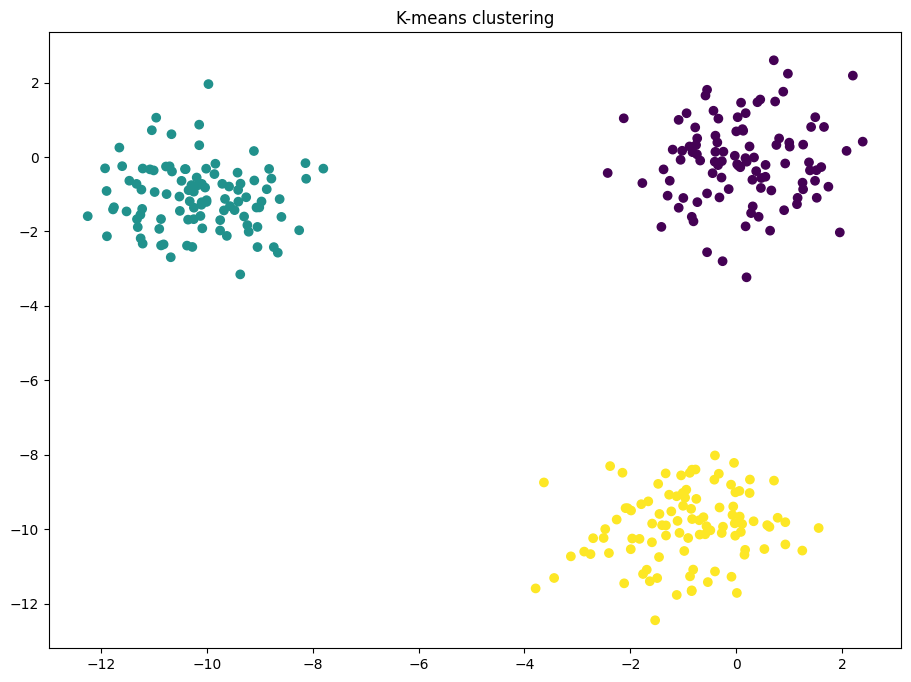

In [5]:
kmeans = KMeans(n_clusters=3)
kmeans = kmeans.fit(X)
clusters = kmeans.predict(X)
plt.scatter(X[:, 0], X[:, 1], c=clusters)
plt.title("K-means clustering")
plt.show();

Let's take a look how cluserization changes while changing number of clusters

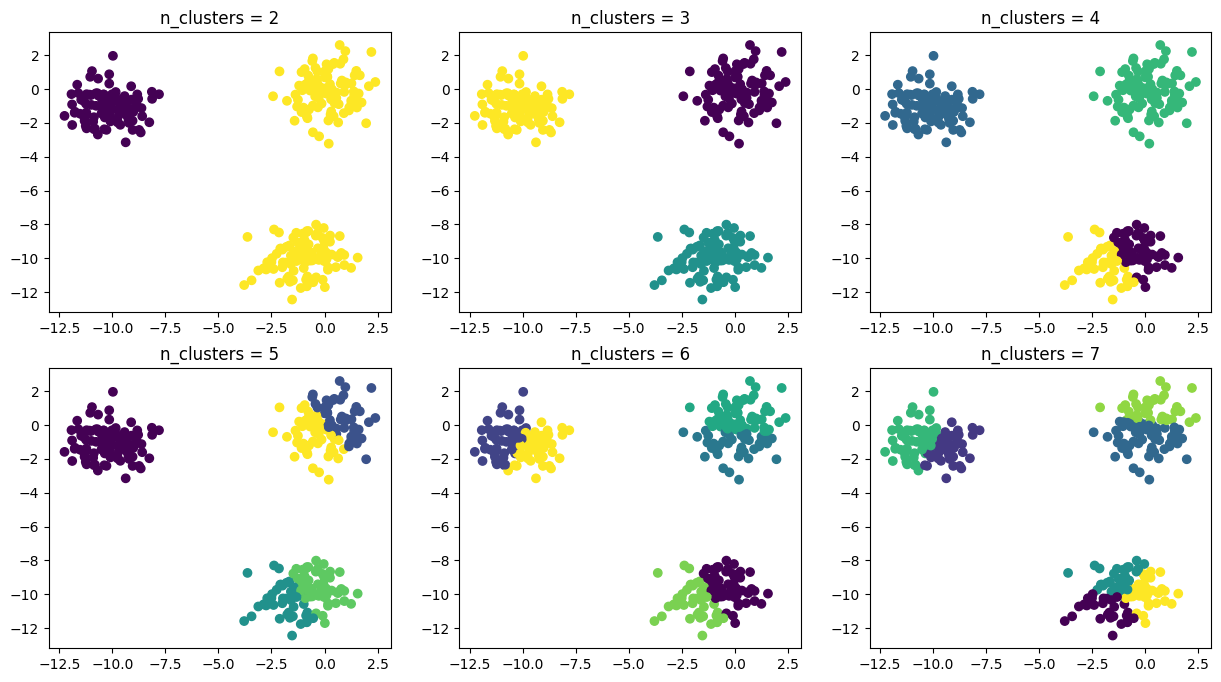

In [6]:
plt.figure(figsize=(15, 8))
for n_c in range(2, 8):
    kmeans = KMeans(n_clusters=n_c)
    kmeans = kmeans.fit(X)
    clusters = kmeans.predict(X)
    plt.subplot(2, 3, n_c - 1)
    plt.scatter(X[:, 0], X[:, 1], c=clusters)
    plt.title(f"n_clusters = {n_c}")
plt.show();

As you can see, knowledge about number of clusters is very important.

<b>How to evaluate quality of clustering in K-means method?</b>

We can use intraclass distance.
$$J(C) = \dfrac{1}{\ell}\sum_{i=1}^{\ell} \rho(x_i, c_{y_i})$$
where
* C - cluster designation
* $x_i$ - object from cluster, its coordinates in features space
* $c_{y_i}$ - coodinate of mass center of the cluster
* $\rho$ - function of distance

To the most quality clustering you must find a value K for which $J$ relatively stable and don't change significantly while further increasing of K. Such a way of parameter selection calls <b>Elbow method</b>.

Here the optimal $K$ is 5.
<center><img src="Elbow.png"></center>
Sometimes Elbow curve looks like a direct line. In such case K-means clustering doesn't work for the given data.

Another method for evaluation of quality (not only for K-means, by the way) is compuutation of <b>Silhouette Coefficient</b>.

For evaluation of clustering quality may be used the following quantities:
* cohesion - the closer objects to each other in the same cluster the better
* separation - the farther objects of different clusters the better

So, based on this quantities can be formulated the <b>Silhouette Coefficient</b>:
$$Sil(X, C) = \dfrac{1}{|C|}\sum_{c_k \in C} \dfrac{1}{|c_k|} \sum_{x_k \in c_k} \dfrac{separation(x_i, c_k) - cohesion(x_i, c_k)}{\max(separation(x_i, c_k), cohesion(x_i, c_k))}$$
where:
* $separation(x_i, c_k)$ - average distance to objects of the nearest cluster
* $cohesion(x_i, c_k)$ - average distance to objects of the same cluster

Values of $Sil(X, C)$ is $-1 \le Sil(X, C) \le 1$, so the closer to 1 the better. Values around 0 is intersected clusters. Negative values is usually sign that 
objects are assigned the wrong cluster, i.e. objects from different clusters are more similar than objects from one.s

In [7]:
from sklearn.metrics import silhouette_score

In [8]:
best_k, best_score = None, -1
for k in range(2, 15):
    k_means = KMeans(n_clusters=k)
    k_means = k_means.fit(X)
    clusters = k_means.predict(X)
    score = np.round(silhouette_score(X=X, labels=clusters), 2)

    if score > best_score:
        best_score = score
        best_k = k

print(f"Best score {best_score}, k = {best_k}")

Best score 0.82, k = 3


# DBSCAN (Density-based spatial clustering of applications with noise)

This algorithm based on density - if we have set of objects in some space, the algorithm groups together objects which located closely and marks as noise objects which located in areas with low density (the nearest neighbours for which are far).

The algorithm has two hyperparameters:
* `eps` - radius of point neighborhood
* `min_samples` - required number of neighbours in point neighborhood

Consider a set of points in some space to be clustered. Let $\varepsilon$ be a parameter specifying the radius of a neighborhood with respect to some point. For the purpose of DBSCAN clustering, the points are classified as core points, (directly-) reachable points and outliers, as follows:

* A point $p$ is a core point if at least minPts points are within distance $\varepsilon$ of it (including $p$).
* A point $q$ is directly reachable from $p$ if point $q$ is within distance $\varepsilon$ from core point $p$. Points are only said to be directly reachable from core points.
* A point $q$ is reachable from $p$ if there is a path $p_1$, ..., $p_n$ with $p_1 = p$ and $p_n = q$, where each $p_{i+1}$ is directly reachable from $p_i$. Note that this implies that the initial point and all points on the path must be core points, with the possible exception of $q$.
* All points not reachable from any other point are outliers or noise points.

Now if $p$ is a core point, then it forms a cluster together with all points (core or non-core) that are reachable from it. Each cluster contains at least one core point; non-core points can be part of a cluster, but they form its "edge", since they cannot be used to reach more points.

<center><img src="Dbscan_picture.png"></center>

Advantage of the approach is possibility of dealing with non-separable data (data with some non-linear dependencies and non standard distributions by its features).

Disadvantage of the approach is obviously 
difficulty in setting u compared to K-means - `eps` is non discrete parameter and setting up may take a lot of time.p

In [9]:
from sklearn.cluster import DBSCAN
import matplotlib as mpl

In [10]:
def get_colors(clusters):
    n_clusters = len(np.unique(clusters[clusters != -1])) # not noise
    palette = mpl.colormaps['viridis'].resampled(n_clusters)(np.linspace(0, 1, n_clusters))
    colors = np.zeros((clusters.shape[0], 4))
    colors[clusters != -1] = palette[clusters[clusters != -1]]

    colors[clusters == -1] = [0.5, 0.5, 0.5, 0.3]

    return colors

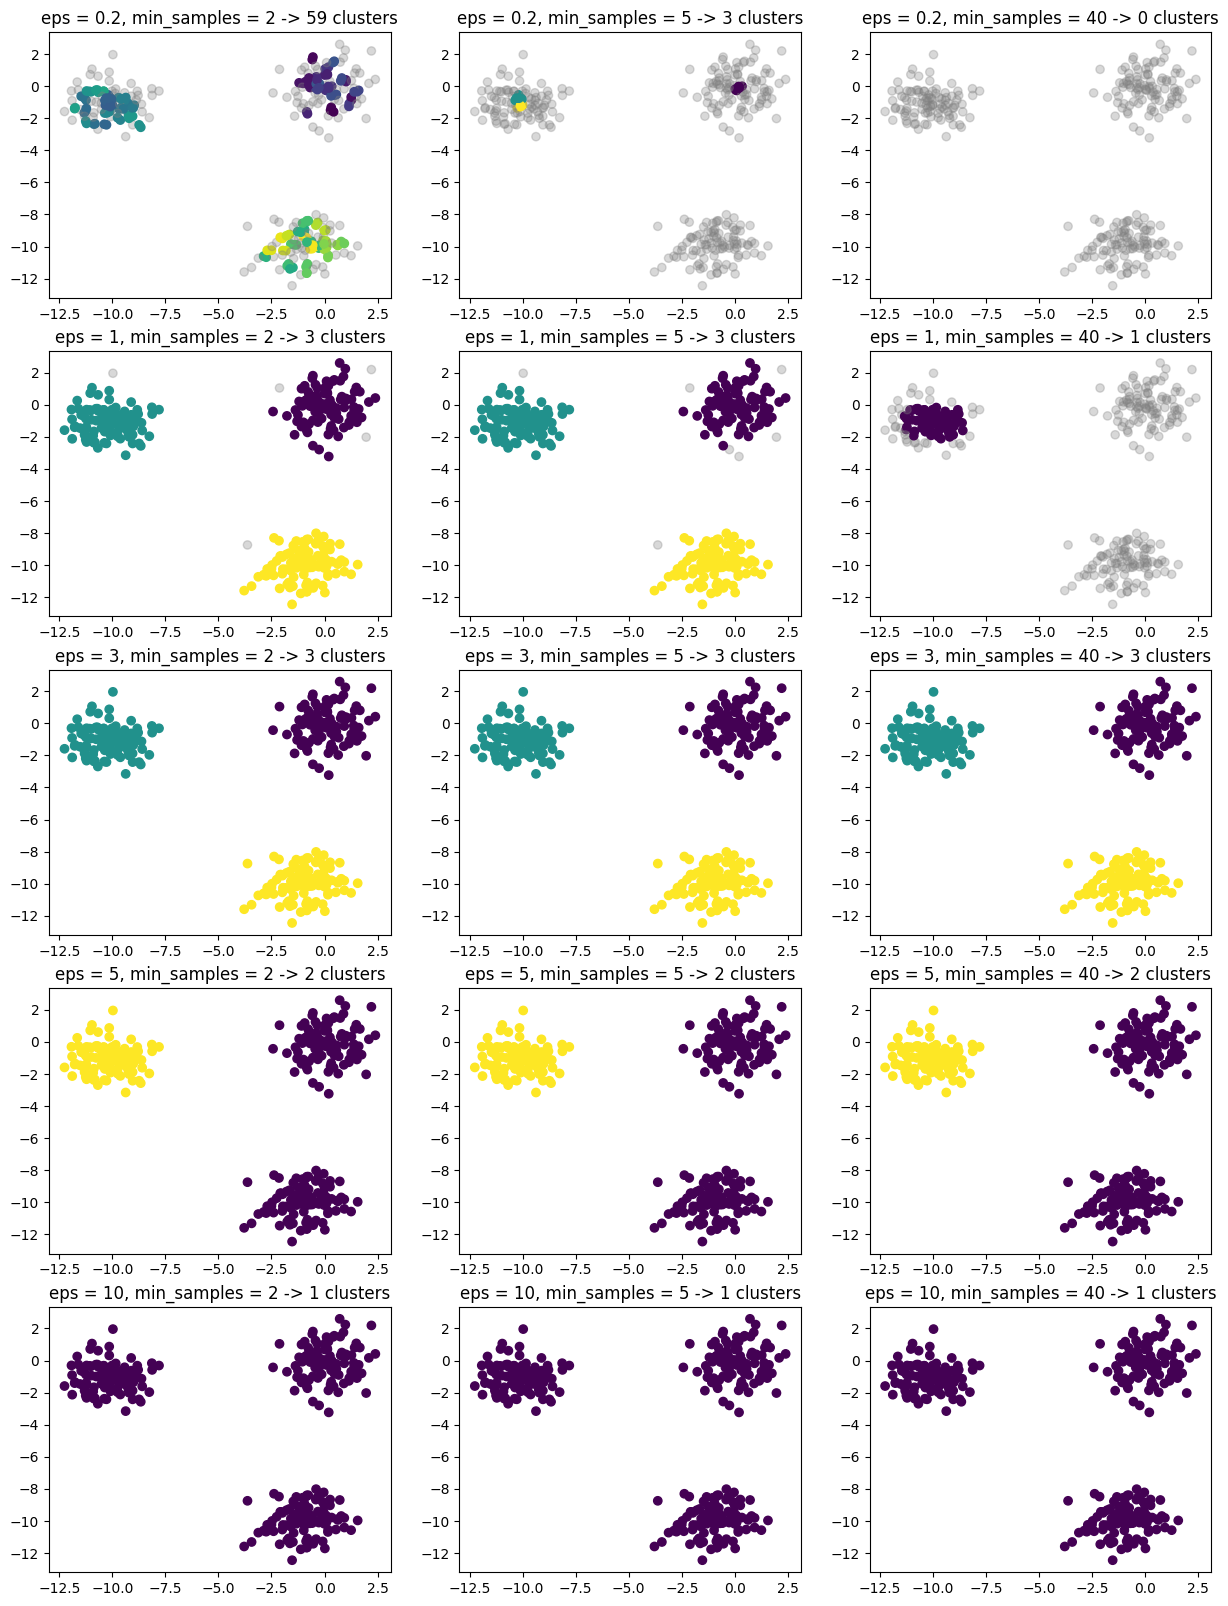

In [11]:
plt.figure(figsize=(15, 20))
i=1

for e in [0.2, 1, 3, 5, 10]:
    for samples in [2, 5, 40]:
        dbscan = DBSCAN(eps=e, min_samples=samples)
        clusters = dbscan.fit_predict(X)

        n_clusters = len(np.unique(clusters[clusters != -1]))
        colors = get_colors(clusters)

        plt.subplot(5, 3, i)
        plt.scatter(X[:, 0], X[:, 1], c=colors)
        plt.title(f"eps = {e}, min_samples = {samples} -> {n_clusters} clusters")
        i+=1

plt.show()

Let's compare DBSCAN and K-means on another dataset.

In [12]:
from sklearn.datasets import make_moons, make_circles

In [13]:
X, y = make_moons(n_samples=500, noise=0.1)

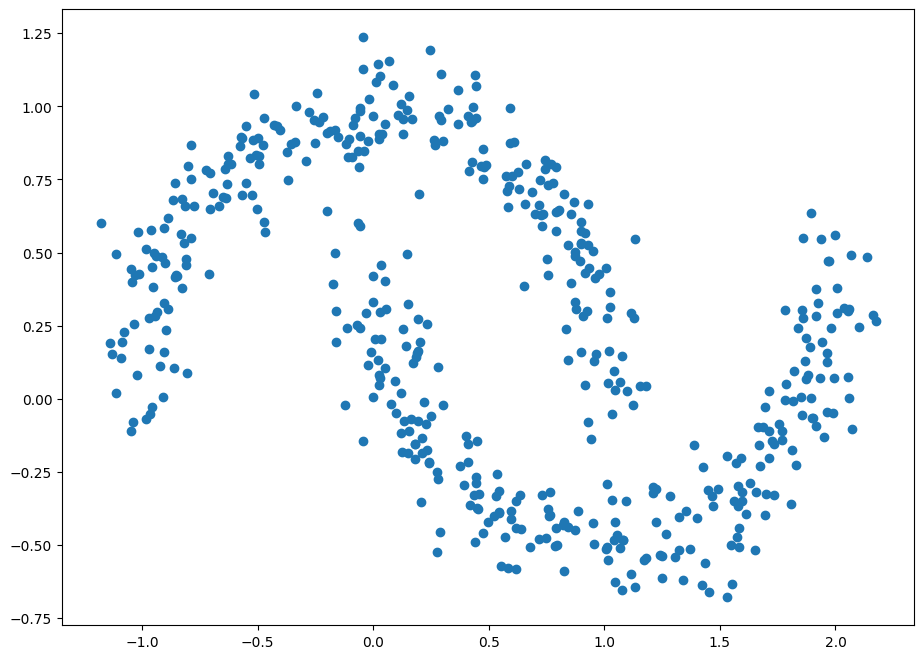

In [14]:
plt.scatter(X[:, 0], X[:, 1])
plt.show();

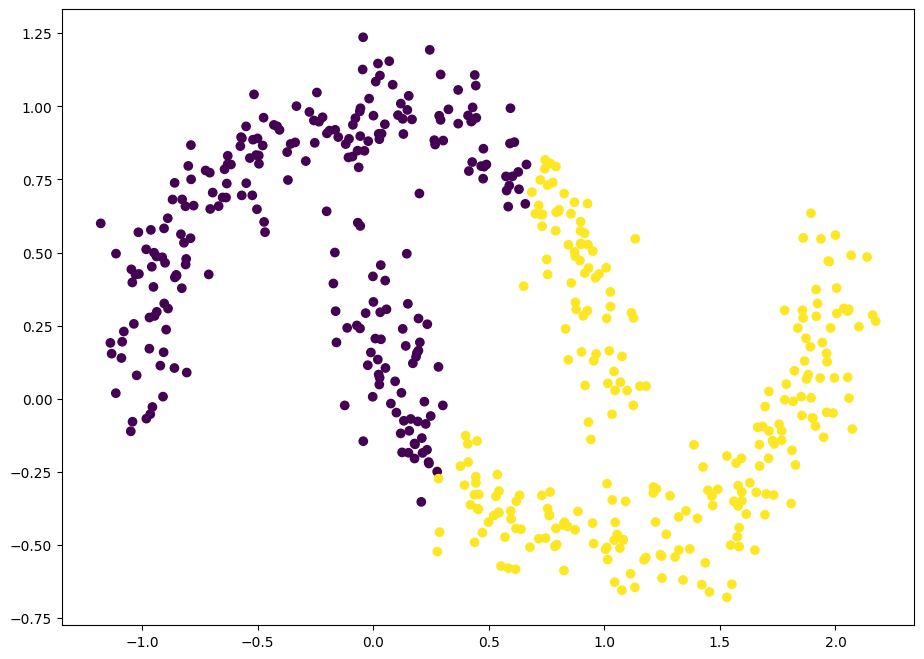

In [15]:
# K-means

k_means = KMeans(n_clusters=2)
k_means = k_means.fit(X)
clusters = k_means.predict(X)

colors = get_colors(clusters)
plt.scatter(X[:, 0], X[:, 1], c=colors)
plt.show()

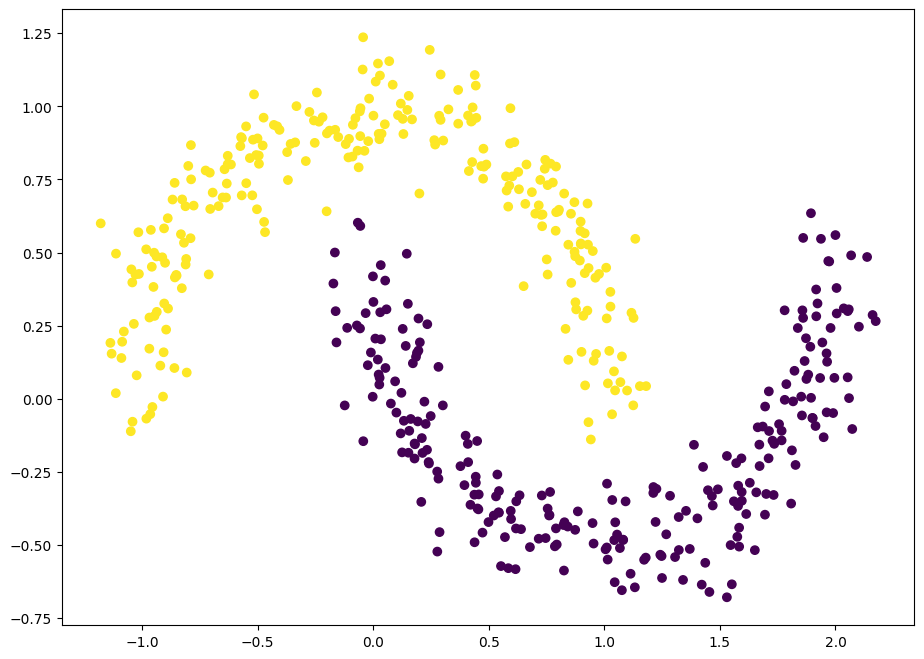

In [16]:
# DBSCAN

dbscan = DBSCAN(eps=0.2, min_samples=10)
clusters = dbscan.fit_predict(X)

colors = get_colors(clusters)
plt.scatter(X[:, 0], X[:, 1], c=colors)
plt.show()

Now let's take a look on a circles.

In [17]:
X, y = make_circles(n_samples=500, noise=0.05, factor=0.5)

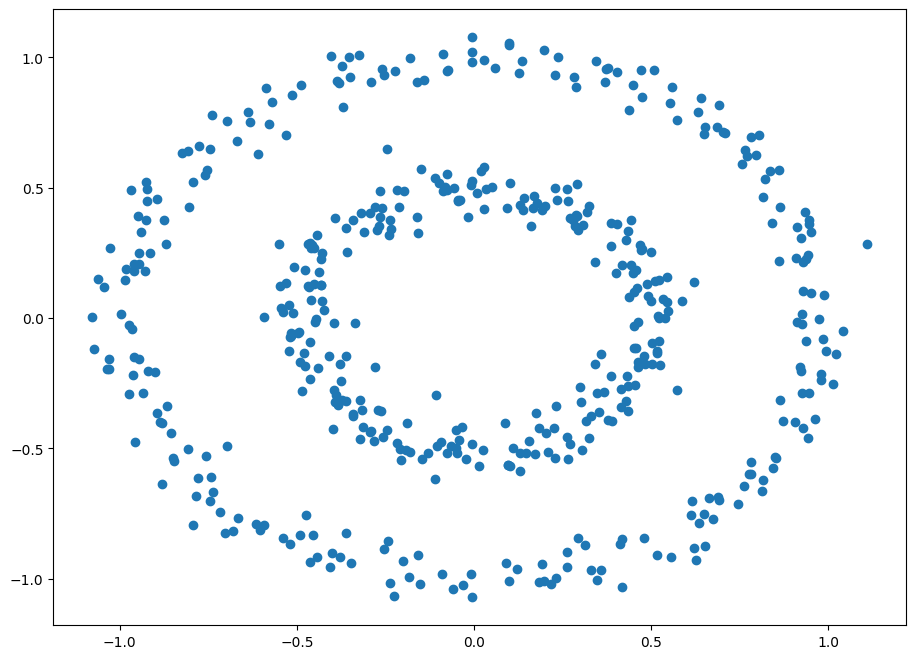

In [18]:
plt.scatter(X[:, 0], X[:, 1])
plt.show();

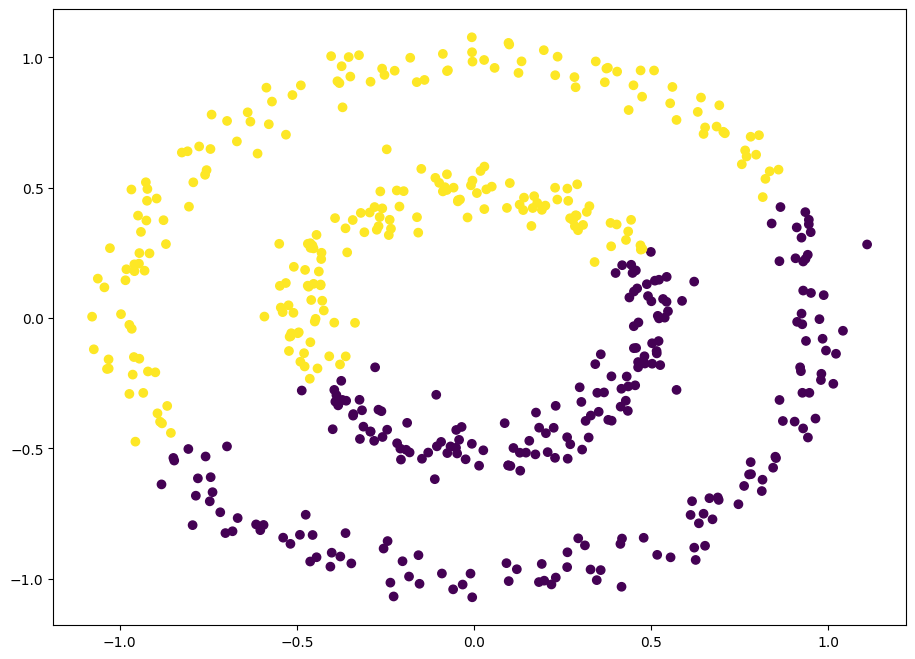

In [19]:
# K-means

k_means = KMeans(n_clusters=2)
k_means = k_means.fit(X)
clusters = k_means.predict(X)

colors = get_colors(clusters)
plt.scatter(X[:, 0], X[:, 1], c=colors)
plt.show()

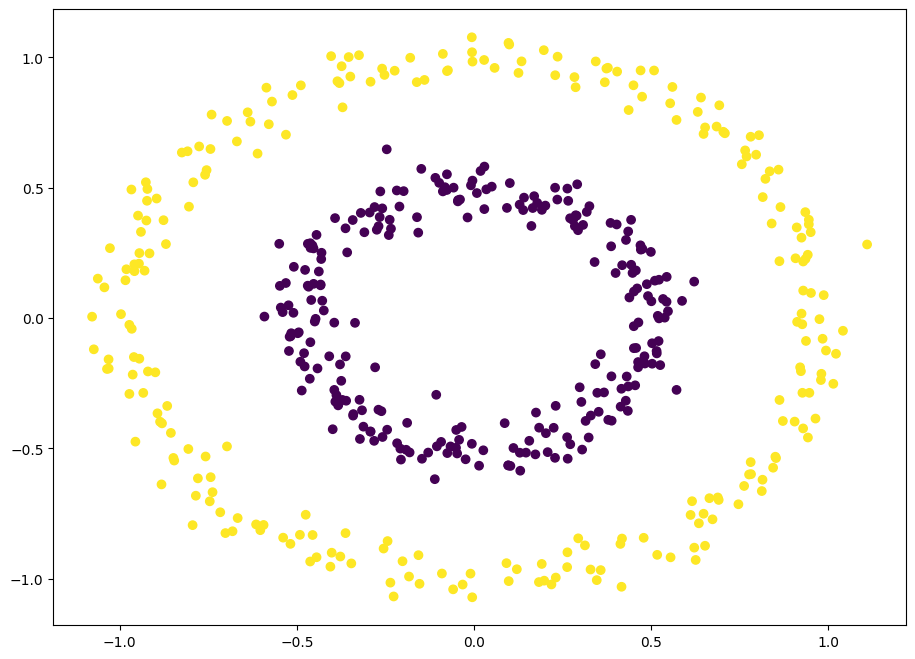

In [20]:
# DBSCAN

dbscan = DBSCAN(eps=0.2, min_samples=10)
clusters = dbscan.fit_predict(X)

colors = get_colors(clusters)
plt.scatter(X[:, 0], X[:, 1], c=colors)
plt.show()

# Hierarchical clustering

This is another approach based on a greedy algorithm.

There are two types of hierarchical clustering:
1. Agglomerative - algorithm on each iteration joins two little clusters into one
2. Divisional - algorithm on each iteration divide one cluster into two smaller

Let's consider agglomerative approach here (divisional can be considered similarly).

Schematically, algorithm of hierarchical clusteringcan can be described the following way:
* While initialization of our set of clusters each point considered as is own cluster. So, for dataset of $N$ cases on the first stage of the algorithm we have $N$ clusters. Also as an input parameter algorithm takes <b>Ward distance</b>:
  $$\Delta = \sum_{x_i \in A \cup B} (x_i - \widetilde{x})^2 - \sum_{x_i \in A} (x_i - \widetilde{a})^2 - \sum_{x_i \in B} (x_i - \widetilde{b})^2$$
  In other words is increase in the sum of squared distances of objects to the center of the cluster obtained as a result of their union.
* On each iteration we join two clusters into one. Joined clusters are chosen in accordance to minimal Ward distance. This is because clusters chosen in accordance to this criterion are most similar, so they must be joined into one cluster.
* Without stoping algorithm works until all points will be joined into one cluster. To choose any number of clusters $K$ in your clustering, you need to stop algorithm on required step.

This algorithm much less sensitive to choose pf metric between points whereas the other algorithms quite strong depends on it.

Let's consider an example

In [21]:
from scipy.cluster.hierarchy import dendrogram
from sklearn.datasets import load_iris
from sklearn.cluster import AgglomerativeClustering

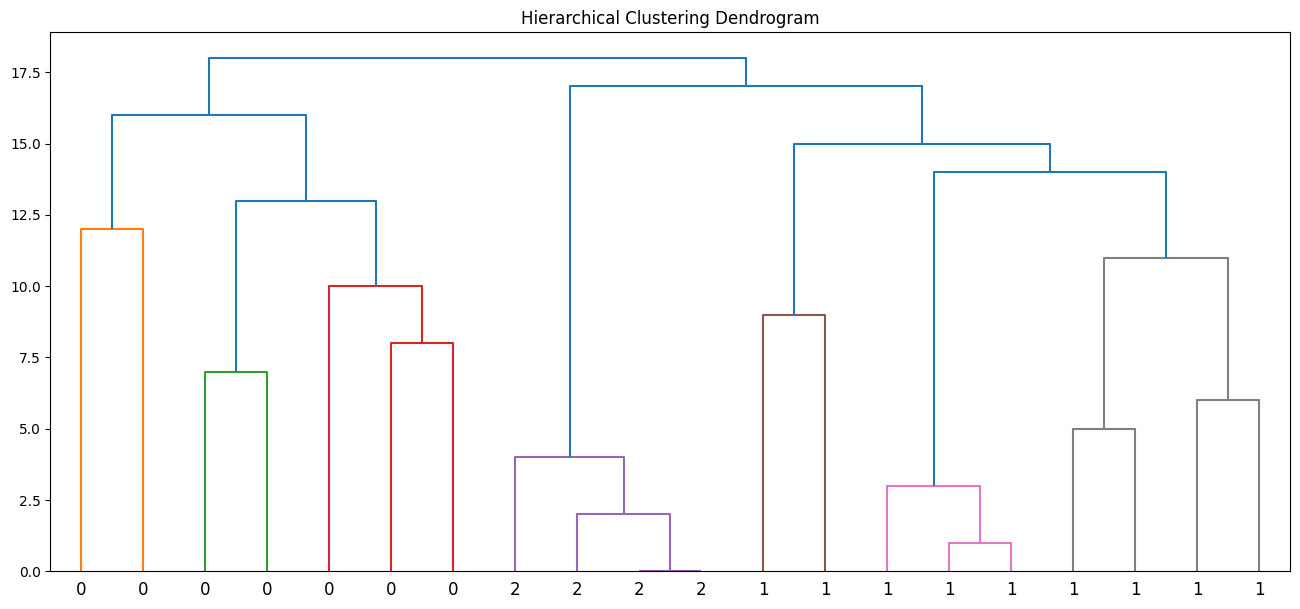

In [22]:
def plot_dendrogram(model, **kwargs):

    # Children of hierarchical clustering
    children = model.children_

    # Distance between each pair of children
    # Since we don't have this information, we can use a uniform one for plotting
    distance = np.arange(children.shape[0])

    # The number of observations contained in each cluster level
    no_of_observations = np.arange(2, children.shape[0]+2)

    # Create linkage matrix and then plot the dendrogram
    linkage_matrix = np.column_stack([children, distance, no_of_observations]).astype(float)

    dendrogram(linkage_matrix, **kwargs)

iris = load_iris()
X = iris.data[: 20]
model = AgglomerativeClustering(n_clusters=3)

model = model.fit(X)
plt.figure(figsize=(16, 7))
plot_dendrogram(model, labels=model.labels_)
plt.title("Hierarchical Clustering Dendrogram")
plt.show();

Let's take a look how hierarchical clustering works with different parameters.

In [23]:
import time
import matplotlib.pyplot as plt
import numpy as np

from sklearn.cluster import AgglomerativeClustering
from sklearn.neighbors import kneighbors_graph

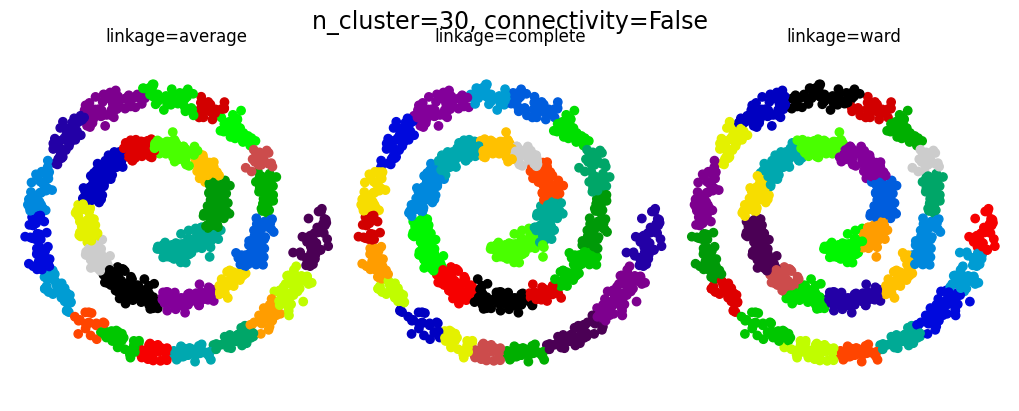

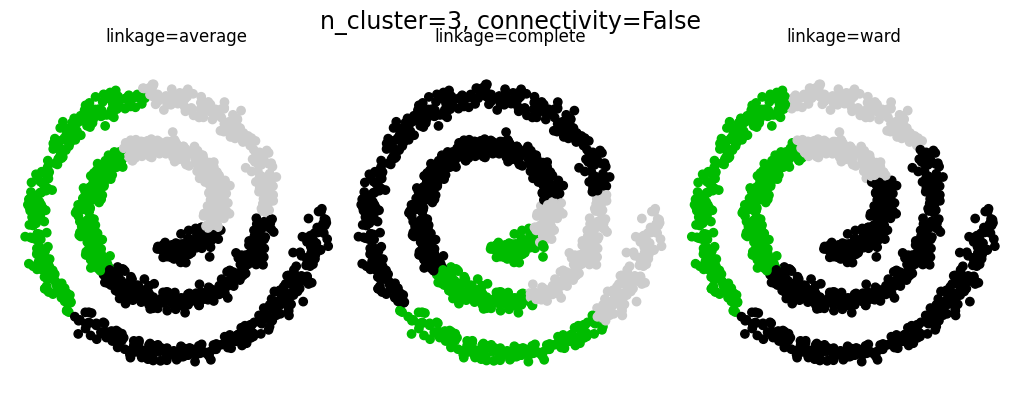

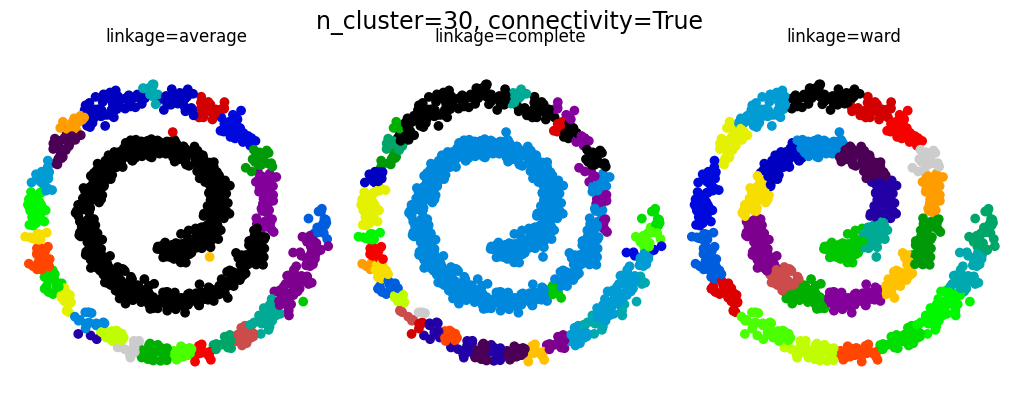

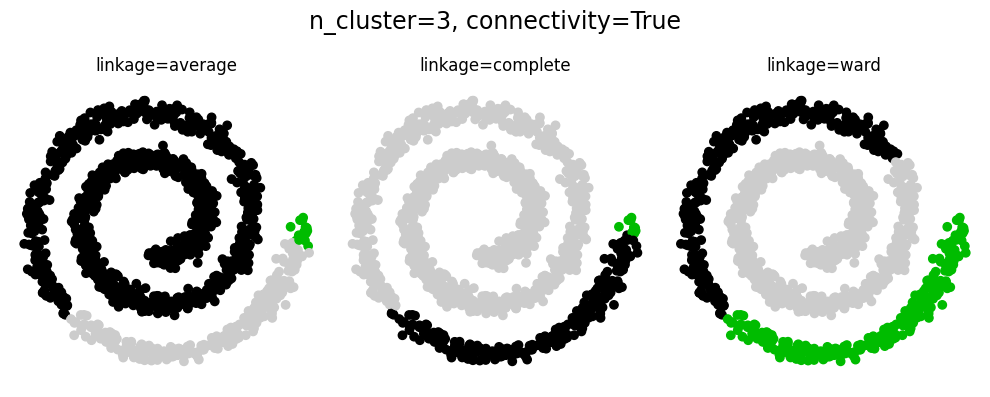

In [24]:
# Generate data sample
n_samples = 1500
np.random.seed(0)
t = 1.5 * np.pi * (1 + 3 * np.random.rand(1, n_samples))
x = t * np.cos(t)
y = t * np.sin(t)

X = np.concatenate((x, y))
X += .7 * np.random.randn(2, n_samples)
X = X.T

knn_graph = kneighbors_graph(X, 30, include_self=False)

for connectivity in (None, knn_graph):
    for n_clusters in (30, 3):
        plt.figure(figsize=(10, 4))
        for index, linkage in enumerate(('average',
                                         'complete',
                                         'ward')):
            plt.subplot(1, 3, index + 1)
            model = AgglomerativeClustering(linkage=linkage,
                                            connectivity=connectivity,
                                            n_clusters=n_clusters)
            model.fit(X)
            plt.scatter(X[:, 0], X[:, 1], c=model.labels_, cmap=plt.cm.nipy_spectral)
            plt.title('linkage=%s' % linkage, fontdict=dict(verticalalignment='top'))
            plt.axis('equal')
            plt.axis('off')
            plt.subplots_adjust(bottom=0, top=.89, wspace=0, left=0, right=1)
            plt.suptitle('n_cluster=%i, connectivity=%r' % (n_clusters, connectivity is not None), size=17)

plt.tight_layout()
plt.show();

Here:
1. linkage - used distance metric
    * `ward` - Ward distance
    * `average` - average distance between all the objects of two clusters
    * `complete` - maximal distance between all the objects of two clusters
2. connectivity - connectivity matrix
    * False - None (no one structure is taken account)
    * True - kneighbors_graph

# Comparison of algorithms

Finally let's compare the algorithms of clustering between each other.

In [25]:
print(__doc__)
import time
import warnings

import numpy as np
import matplotlib.pyplot as plt

from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice

Automatically created module for IPython interactive environment


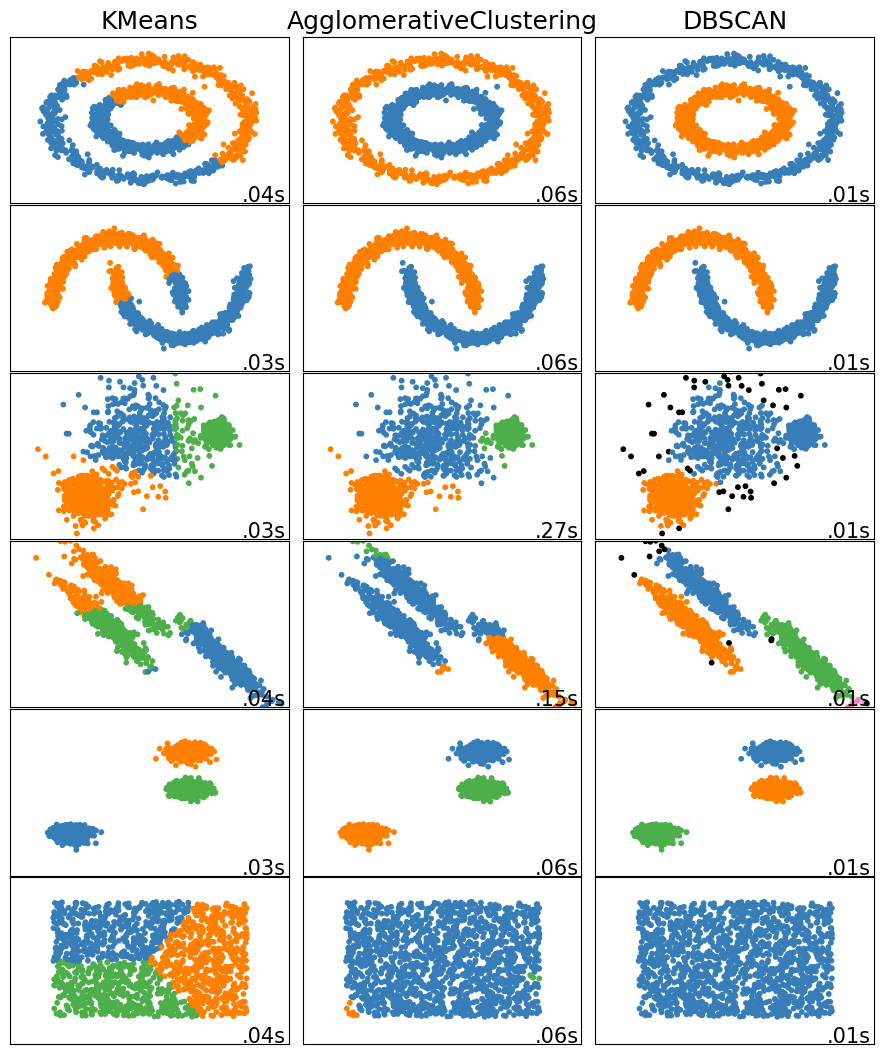

In [26]:
warnings.simplefilter('ignore')

np.random.seed(0)

# Generate datasets
n_samples = 1500
noisy_circles = datasets.make_circles(n_samples=n_samples, factor=.5, noise=.05)
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=.05)
blobs = datasets.make_blobs(n_samples=n_samples, random_state=8)
no_structure = np.random.rand(n_samples, 2), None

# Anisotropicly distributed data
random_state = 170
X, y = datasets.make_blobs(n_samples=n_samples, random_state=random_state)
transformation = [[0.6, -0.6], [-0.4, 0.8]]
X_aniso = np.dot(X, transformation)
aniso = (X_aniso, y)

# blobs with varied variances
varied = datasets.make_blobs(n_samples=n_samples,
                             cluster_std=[1.0, 2.5, 0.5],
                             random_state=random_state)

# setup cluster parameters
plt.figure(figsize=(3 * 2 + 3, 10.5))
plt.subplots_adjust(left=.02, right=.98, bottom=.001, top=.96, wspace=.05, hspace=.01)

plot_num = 1

default_base = {'quantile': .3,
                'eps': .3,
                'damping': .9,
                'preference': -200,
                'n_neighbors': 10,
                'n_clusters': 3,
                'min_samples': 20,
                'xi': 0.05,
                'min_cluster_size': 0.1}
datasets = [
    (noisy_circles, {'damping': .77, 'preference': -240,
                     'quantile': .2, 'n_clusters': 2,
                     'min_samples': 20, 'xi': 0.25}),
    (noisy_moons, {'damping': .75, 'preference': -220, 'n_clusters': 2}),
    (varied, {'eps': .18, 'n_neighbors': 2, 'min_samples': 5, 'xi': 0.035, 'min_cluster_size': 0.2}),
    (aniso, {'eps': .15, 'n_neighbors': 2, 'min_samples': 20, 'xi': 0.1, 'min_cluster_size': 0.2}),
    (blobs, {}),
    (no_structure, {})]

for i_dataset, (dataset, algo_params) in enumerate(datasets):
    # update parameters with dataset-specific values
    params = default_base.copy()
    params.update(algo_params)
    
    X, y = dataset
    
    # normalize dataset for easier parameter selection 
    X = StandardScaler().fit_transform(X)
    connectivity = kneighbors_graph(
        X, n_neighbors=params['n_neighbors'], include_self=False)
    
    # make connectivity symmetric
    connectivity = 0.5 * (connectivity + connectivity.T)
    
    # Create cluster object
    k_means = cluster.KMeans(n_clusters=params['n_clusters'])
    
    dbscan = cluster.DBSCAN(eps=params['eps'])
    
    average_linkage = cluster.AgglomerativeClustering(
        linkage='average', affinity='cityblock',
        n_clusters=params['n_clusters'], connectivity=connectivity)
    
    clustering_algorithms = (
        ("KMeans", k_means),
        ("AgglomerativeClustering", average_linkage),
        ("DBSCAN", dbscan),
    )
    
    for name, algorithm in clustering_algorithms:
        t0 = time.time()
        
        algorithm.fit(X)
        
        t1 = time.time()
        if hasattr(algorithm, "labels_"):
            y_pred = algorithm.labels_.astype(int)
        else:
            y_pred = algorithm.predict(X)
        
        plt.subplot(len(datasets), len(clustering_algorithms), plot_num)
        if i_dataset == 0:
            plt.title(name, size=18)
        
        colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a',
                                             '#f781bf', '#a65628', '#984ea3',
                                             '#999999', '#e41a1c', '#dede00']),
                                     int(max(y_pred) + 1))))
        
        # add black color for outliers (if any)
        colors = np.append(colors, ['#000000'])
        plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[y_pred])
        
        plt.xlim(-2.5, 2.5)
        plt.ylim(-2.5, 2.5)
        plt.xticks(())
        plt.yticks(())
        plt.text(.99, .01, ('%.2fs' % (t1 - t0)).lstrip('0'),
                transform=plt.gca().transAxes, size=15,
                horizontalalignment='right')
        plot_num += 1

plt.show();